In [1]:
## Step 1: Download the model and dataset

In [2]:
!pip install datasets --quiet

In [3]:
from datasets import load_dataset

dataset = load_dataset('bazyl/GTSRB')

with open('params.json', 'rb') as f:
    params = json.load(f)
    class_n = params['GTSRB']['class_n']
    device = params['device']
    position_list, mask_list = load_mask()

# Load the model
model = GtsrbCNN(n_class=class_n).to(device)
model.load_state_dict(
    torch.load(f'./model/model_gtsrb.pth',
                map_location=torch.device(device)))
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
### This is an aside. It is exclusively for finding large images to visualize

In [4]:
my_list = (dataset['train']['Width'])
indices = [index for index, element in enumerate(my_list) if element > 126]


In [9]:
## Step 2: Run the model on a specific data point
### Jacob's comment March 31 2024: It seems most of this work is already done for me

In [10]:
!git clone https://github.com/hncszyq/ShadowAttack.git

from google.colab import drive
drive.mount('/content/drive')

!unzip -q /content/drive/MyDrive/data/dataset.zip -d /content/ShadowAttack/dataset
!unzip -q /content/drive/MyDrive/data/model.zip -d /content/ShadowAttack/model

!pip install grad-cam --quiet

import sys
import os

directory_path = '/content/ShadowAttack'
sys.path.append(directory_path)
os.chdir('/content/ShadowAttack')

fatal: destination path 'ShadowAttack' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/ShadowAttack/dataset/LISA/test.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace /content/ShadowAttack/model/model_gtsrb.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
import cv2
import json
import torch

import numpy as np
import matplotlib.pyplot as plt

from gtsrb import GtsrbCNN
from utils import load_mask

from gtsrb import test_single_image, pre_process_image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import scale_cam_image, show_cam_on_image

In [16]:
from PIL import Image
import tempfile

def pred_image(pil_file, label):
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        pil_file.save(tmpfile, format='PNG')

        label, correct = test_single_image(tmpfile.name, label)

    return label

In [17]:
img = dataset['train'][688]['Path']
label = dataset['train'][688]['ClassId']

pred_image(img, label)

Correct: True Predict: 1 Confidence: 91.11471176147461%


1

In [18]:
## Step 3: Attack that datapoint to create an adversarially modified image

In [25]:
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
    img.save(tmpfile, format='PNG')

In [ ]:
!python shadow_attack.py --shadow_level 0.43 --attack_db GTSRB --attack_type physical --image_path ./tmp/gtsrb_30.png --mask_path ./tmp/gtsrb_30_mask.png --image_label 1

In [ ]:
### Hmm... need to create a mask file. How to do so?

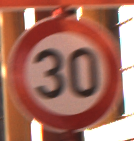

In [23]:
img

In [ ]:
import torch
import torchvision

import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [27]:
image = cv2.imread(tmpfile.name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [29]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [30]:
masks = mask_generator.generate(image)

In [ ]:
masks

In [33]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [38]:
image.shape

(141, 134, 3)

In [47]:
masks[1]['area']

10710

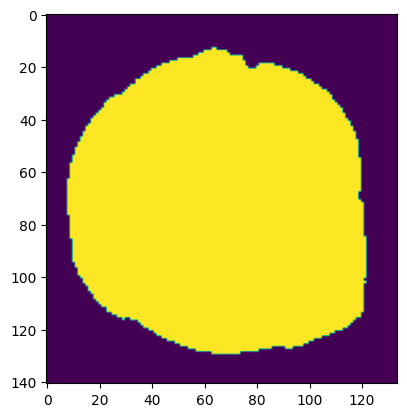

In [44]:
plt.imshow(masks[1]['segmentation'])

In [74]:
mask = Image.fromarray( masks[1]['segmentation'] ).convert("RGB")

In [75]:
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as maskfile:
    mask.save(maskfile, format='PNG')

In [77]:
mask = Image.open("/content/ShadowAttack/tmp/gtsrb_30_mask.png")
print(np.array(mask).shape)

(240, 240, 3)


In [78]:
mask = Image.open(maskfile.name)
print(np.array(mask).shape)

(141, 134, 3)


In [81]:
print(label)
print(maskfile.name)
print(tmpfile.name)

1
/tmp/tmp76r0qrj9.png
/tmp/tmp11jbo_23.png


In [84]:
print(tmpfile.name)

/tmp/tmp11jbo_23.png


In [ ]:
!python shadow_attack.py --shadow_level 0.43 --attack_db GTSRB --attack_type physical --image_path /tmp/tmp11jbo_23.png --mask_path /tmp/tmp76r0qrj9.png --image_label 1

In [19]:
## Step 4: Run the model on the adversarially modified image to show that the attack worked

In [87]:
test_single_image("./tmp/adv_img.png", label)

Correct: False Predict: 40 Confidence: 24.87131506204605%


(40, False)

In [ ]:
# Done! Now I need to clean and get explainations working